** $$ {\color{red}{ \large \text{THIS IS MY FIRST ATTEMPT AT THE DSB2018 CHALLENGE. }}} $$**

I SIMPLY USED A FCN FOR SEMANTIC SEGMENTATION OF NUCLEI FROM THE MICROSCOPIC IMAGES

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
from skimage.io import imread
from skimage.transform import rotate
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd
from skimage.morphology import label, binary_dilation
from skimage import filters
from skimage.transform import resize

from sklearn.model_selection import train_test_split

# CONSTANTS
Train_Path = '.\\DataSet\\stage1_train\\*' # DSB2018 Train Data Path
Test_Path = '.\\DataSet\\stage1_test\\*'   # DSB2018 Test  Data Path

In [4]:
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Dropout, Input, MaxPooling2D, Conv2DTranspose
from keras.layers import Concatenate
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
import keras.callbacks as CallBacks
from keras import backend as K
import tensorflow as tf

In [20]:
def Gen_Buckets(Images, Masks, return_sizes = False): # BUCKETING IMAGES WITH SAME RESOLUTION TOGETHER
    Shape = [[image.shape[0], image.shape[1]] for image in Images]
    Unique_Shapes = np.unique(Shape, axis=0)

    Image_Buckets = []
    Mask_Buckets = []
    for shape in Unique_Shapes:
        image_bucket = []
        mask_bucket = []
        for image, mask in zip(Images, Masks):
            if (image.shape[0] ==  shape[0]) &  (image.shape[1] == shape[1]):
                image_bucket.append(image)
                mask_bucket.append(mask)
        Image_Buckets.append(np.array(image_bucket))
        Mask_Buckets.append(np.array(mask_bucket))
    if return_sizes:
        return Image_Buckets, Mask_Buckets, Unique_Shapes
    else:
        return Image_Buckets, Mask_Buckets

def Normalize_Images(Images, divide_by = 255): # Normalizing Images B/W 0 and 1.
    if divide_by == 'max':
        return [ image/image.max() for image in Images]
    else:
        return [ image/divide_by for image in Images]
    
# Augmentated Image Generator
def Augment_Images(Images, Masks, fliplr = True, flipud = True, Rot = None, 
                   Rot_Mode = 'edge', Rot90 = True, return_numpy=True):
    # Rot  = Does small angular rotations but keeps the dimensions same.
    # Rot90= Rotates image by multiples of 90 degree and changes the dimensions
    Aug_Images = []
    Aug_Mask =   []
    for image, mask in zip(Images, Masks):
        aug_img = image
        aug_mask = mask
        if fliplr:
            if np.random.uniform(low=0, high=1) > 0.5:
                aug_img = np.fliplr(aug_img)
                aug_mask = np.fliplr(aug_mask)
        if flipud:
            if np.random.uniform(low=0, high=1) > 0.5:
                aug_img = np.flipud(aug_img)
                aug_mask = np.flipud(aug_mask)
        if Rot90:
            if np.random.uniform(low=0, high=1)>0.5:
                k = np.random.randint(low=0, high=4)
                aug_img = np.rot90(aug_img, k = k, axes=(0,1))
                aug_mask = np.rot90(aug_mask, k = k, axes=(0,1))
        if Rot != None:
            if np.random.uniform(low=0, high=1) > 0.5:
                angle = np.random.uniform(low=0, high = Rot)
                aug_img = rotate(aug_img, angle, mode = Rot_Mode)
                aug_mask = rotate(aug_mask, angle, mode = Rot_Mode)
        Aug_Images.append(aug_img)
        Aug_Mask.append(aug_mask)
        
    if return_numpy:
        return np.array(Aug_Images), np.array(Aug_Mask)
    return Aug_Images, Aug_Mask

# Rescaling the Images
def Rescale_Images(Images, Masks, size=(256,256), order=3, mode='constant'):
    Images_Resized = []; Masks_Resized = [];
    if Masks == None:
        for image in Images:
            img = resize(image, size, order, mode, preserve_range = True )
            Images_Resized.append(img)
        return np.array(Images_Resized)
    else:
        for image, mask in zip(Images, Masks):
            img = resize(image, size, order, mode, preserve_range = True )
            msk = resize(mask,  size, order, mode, preserve_range = True )

            Images_Resized.append(img)
            Masks_Resized.append(msk)
        
        return np.array(Images_Resized), np.array(Masks_Resized)

def Load_Training_Data(Train_Path, return_mask_report=True):
    Images = []
    Masks = []     # Stores masks by adding them
    Masks_Obj = [] # Stores masks as is, donot add
    Number_Of_Masks = []
    for path in tqdm(glob(Train_Path)):
        image_path = glob(path + '\\images\\*.png')
        assert len(image_path) == 1
        Images.append(imread(image_path[0])[:,:,:3])    
        masks = glob(path + '\\masks\\*.png')
        mask = []
        for m in masks:
            mask.append(imread(m))
        Number_Of_Masks.append(len(mask))
        Masks_Obj.append(np.array(mask))
        mask = np.sum(mask, axis=0)
        mask = np.expand_dims(mask, axis=-1)
        Masks.append(mask)
    if return_mask_report:
        return Images, Masks,Masks_Obj, np.array(Number_Of_Masks)
    else:
        return Images, Masks,Masks_Obj
    
def Load_Test_Data(Test_Path, return_testid=True):
    Test_Images = []
    Test_Id = []
    for path in tqdm(glob(Test_Path)):
        image_path = glob(path + '\\images\\*.png')
        test_id = glob(path + '\\images\\*.png')[0].split('\\')[-1][:-4]
        assert len(image_path) == 1
        Test_Images.append(imread(image_path[0])[:,:,:3])    
        Test_Id.append(test_id)
    if return_testid:
        return Test_Images, Test_Id
    else:
        return Test_Images

In [48]:
# LOADING TRAINING DATA
Images, Masks, Masks_Obj, Number_Of_Masks = Load_Training_Data(Train_Path, return_mask_report=True )

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:38<00:00,  6.82it/s]


# Removing Outliers and Pre-Processing Data for Training

We check for any mask that does not have labels for objects in the microscopic images. We see that image at index = 332 does not masks for all the objects in the image. We remove this image from the dataset.

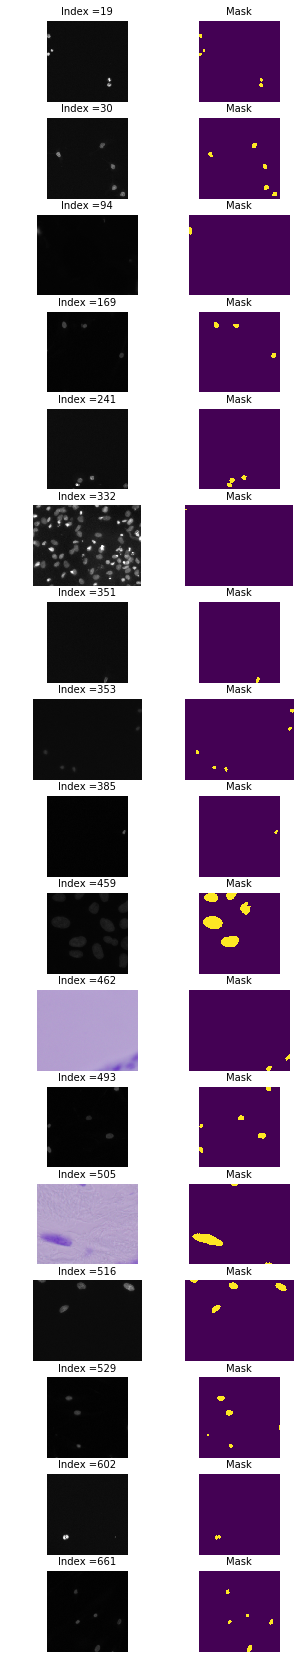

In [49]:
# ANALYSING NUMBER OF MASK FOR OUTLIERS IN DATA
Threshold_On_Masks = 6
idx = np.argwhere(Number_Of_Masks < Threshold_On_Masks).reshape(-1)
Images_Outliers = []
Masks_Outliers = []
for i in idx:
    Images_Outliers.append(Images[i])
    Masks_Outliers.append(Masks[i])
f, ax = plt.subplots(idx.shape[0], 2, figsize=(5,30))
for i in range(idx.shape[0]):
    ax[i,0].imshow(Images_Outliers[i])
    ax[i,0].set_title(str('Index ='+ str(idx[i])), size=10)
    ax[i,1].imshow(Masks_Outliers[i][:,:,0])
    ax[i,1].set_title('Mask', size=10)
    ax[i,0].axis('Off')
    ax[i,1].axis('Off')
plt.show()

In [50]:
# Deleting Outlier from Images
del_idx = [332, 36] # Also 36 because no such image is present in Test Set.
for idx in del_idx:
    del Images[idx]
    del Masks[idx]
    del Masks_Obj[idx]

In [51]:
# UNIQUE SIZES IN TRAINING DATASET
_,_, sizes = Gen_Buckets(Images, Masks, return_sizes=True)
print('Unique Images Sizes in Training Data = ')
print(sizes)

Unique Images Sizes in Training Data = 
[[ 256  256]
 [ 256  320]
 [ 512  640]
 [1024 1024]
 [ 260  347]
 [ 520  696]
 [1040 1388]
 [ 603 1272]
 [ 360  360]]


We normalize images between 0 and 1 and rescale all images to 128x128.

In [52]:
# Normalizing Images
Images = Normalize_Images(Images, divide_by = 255)
Masks = Normalize_Images(Masks, divide_by = 255)

In [53]:
# Rescaling Training Data
Images, Masks = Rescale_Images(Images, Masks, size=(128,128), order=0, mode='constant')

# Splitting Training and Validation Data and Applying Augmentations

In [56]:
X_Train, X_Val, Mask_Train, Mask_Val = train_test_split( Images, Masks, test_size=0.1, random_state=42)

In [57]:
del Images, Masks

In [58]:
AugmentFactor = 2 # Generates 2 random augmented versions of X_Train and concatenates with X_Train
for i in tqdm(range(AugmentFactor)):
    image, mask = Augment_Images(X_Train, Mask_Train, 
                                 fliplr = True, flipud = True, 
                                 Rot = 3, Rot_Mode = 'edge', 
                                 Rot90 = True)
    X_Train = np.concatenate([X_Train, image], axis=0)
    Mask_Train = np.concatenate([Mask_Train, mask], axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]


In [28]:
# X_Train_Buckets, Mask_Train_Buckets = Gen_Buckets(X_Train, Mask_Train)
# X_Val_Buckets,  Mask_Val_Buckets = Gen_Buckets(X_Val, Mask_Val) 

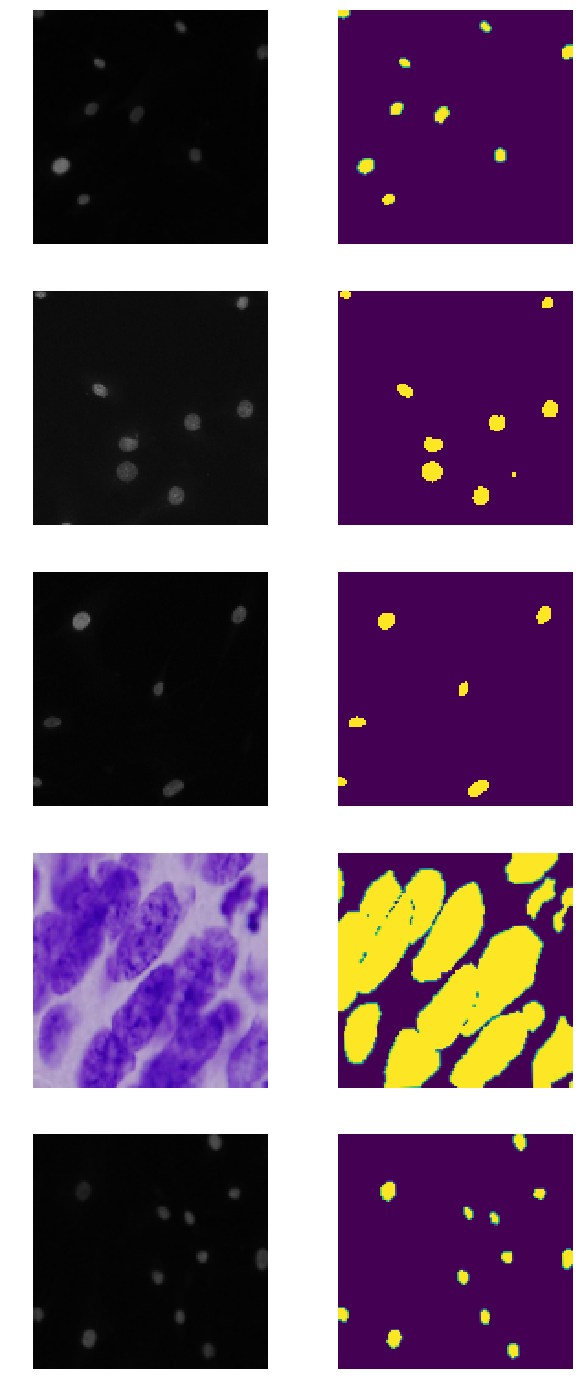

In [64]:
# Visualizing Results
N = 5
idx = np.random.randint(len(X_Train), size=(N,))

f, ax = plt.subplots(N,2,figsize=(10,5*N))
for i in range(N):
    ax[i,0].imshow(X_Train[int(idx[i])])
    ax[i,1].imshow(Mask_Train[int(idx[i])][:,:,0],)
    ax[i,0].axis('Off')
    ax[i,1].axis('Off')
plt.show()

In [84]:
alpha = 0.1
drop_rate = [0.1,0.2,0.25,0.3,0.5]
drop_rate = [0,  0,  0,   0,  0]

# KERAS MODEL DEF.
FCN_Input = Input(shape=(128, 128,3))

Hidden_Layer = Conv2D(32, kernel_size=(3,3), strides = (1,1), padding = 'same')(FCN_Input)
Hidden_Layer = LeakyReLU(alpha = alpha)(Hidden_Layer)
Hidden_Layer = Dropout(rate = drop_rate[0])(Hidden_Layer)
Hidden_Layer =  BatchNormalization()(Hidden_Layer)

Hidden_Layer = Conv2D(64, kernel_size=(3,3), strides = (1,1), padding = 'same')(Hidden_Layer)
Hidden_Layer = LeakyReLU(alpha = alpha)(Hidden_Layer)
Hidden_Layer = Dropout(rate = drop_rate[1])(Hidden_Layer)
Hidden_Layer =  BatchNormalization()(Hidden_Layer)

Hidden_Layer = Conv2D(128, kernel_size=(3,3), strides = (1,1), padding = 'same')(Hidden_Layer)
Hidden_Layer = LeakyReLU(alpha = alpha)(Hidden_Layer)
Hidden_Layer = Dropout(rate = drop_rate[2])(Hidden_Layer)
Hidden_Layer =  BatchNormalization()(Hidden_Layer)

Hidden_Layer = Conv2D(256, kernel_size=(2,2), strides = (1,1), padding = 'same')(Hidden_Layer)
Hidden_Layer = LeakyReLU(alpha = alpha)(Hidden_Layer)
Hidden_Layer = Dropout(rate = drop_rate[3])(Hidden_Layer)
Hidden_Layer =  BatchNormalization()(Hidden_Layer)

FCN_Output = Conv2D(1, kernel_size=(1,1), strides = (1,1), padding='same', activation='sigmoid')(Hidden_Layer)

FCN = Model(FCN_Input, FCN_Output)

In [85]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [86]:
LearningRate = 0.0001
BatchSize = 3  

sgd = SGD(lr = LearningRate, momentum = 0.9)
adam = Adam(lr = LearningRate)
FCN.compile(optimizer = adam, loss = 'binary_crossentropy', metrics=['accuracy', mean_iou] )
FCN.load_weights('.\FCN\FCN - Weights.h5')

In [36]:
# FCN.save_weights('FCN - Weights.h5')

In [87]:
checkpoints = CallBacks.ModelCheckpoint('./FCN/checkpoints/', monitor= 'val_loss', verbose=0, 
                save_best_only=True, save_weights_only=False, mode='auto', period=1)

tensorboard = CallBacks.TensorBoard(log_dir='./FCN/logs', histogram_freq=0, batch_size=BatchSize, 
                      write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, 
                      embeddings_layer_names=None, embeddings_metadata=None)

red_lr = CallBacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto', 
                  epsilon=0.0001, cooldown=0, min_lr=0.000001)

callbacks = [ tensorboard, red_lr]

In [35]:
hist = FCN.fit(X_Train, Mask_Train, validation_data=(X_Val, Mask_Val), 
               batch_size = BatchSize, epochs = 10 ,shuffle=True, verbose=2, callbacks = callbacks )        

Train on 14976 samples, validate on 201 samples
Epoch 1/10
 - 215s - loss: 0.1530 - acc: 0.8478 - mean_iou: 0.7096 - val_loss: 0.1354 - val_acc: 0.9237 - val_mean_iou: 0.7271
Epoch 2/10
 - 217s - loss: 0.1043 - acc: 0.8535 - mean_iou: 0.7307 - val_loss: 0.1365 - val_acc: 0.9099 - val_mean_iou: 0.7341
Epoch 3/10
 - 218s - loss: 0.0984 - acc: 0.8547 - mean_iou: 0.7360 - val_loss: 0.1198 - val_acc: 0.9286 - val_mean_iou: 0.7386
Epoch 4/10
 - 219s - loss: 0.0943 - acc: 0.8559 - mean_iou: 0.7405 - val_loss: 0.1441 - val_acc: 0.9113 - val_mean_iou: 0.7422
Epoch 5/10
 - 219s - loss: 0.0915 - acc: 0.8567 - mean_iou: 0.7438 - val_loss: 0.2011 - val_acc: 0.8959 - val_mean_iou: 0.7452
Epoch 6/10
 - 218s - loss: 0.0900 - acc: 0.8570 - mean_iou: 0.7464 - val_loss: 0.1859 - val_acc: 0.8987 - val_mean_iou: 0.7474
Epoch 7/10
 - 217s - loss: 0.0883 - acc: 0.8575 - mean_iou: 0.7484 - val_loss: 0.0975 - val_acc: 0.9377 - val_mean_iou: 0.7495
Epoch 8/10
 - 216s - loss: 0.0875 - acc: 0.8577 - mean_iou: 0.7

# GENERATING TEST PREDICTIONS

In [90]:
# LOading TEST DATA
Test_Images_Orig, Test_Id = Load_Test_Data(Test_Path,return_testid = True )
Orig_Shape = [ image.shape[:-1] for image in Test_Images_Orig]
Test_Images = Normalize_Images(Test_Images_Orig, divide_by = 255)
Test_Images = Rescale_Images(Test_Images, Masks=None, size=(128,128), order=3, mode='constant')

100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 169.87it/s]


In [91]:
Pred_Masks = FCN.predict(Test_Images)[:,:,:,0]
Pred_Masks_upsampled = []
for i in range(Pred_Masks.shape[0]):
    mask_upsampled = resize(Pred_Masks[i], Orig_Shape[i], order = 1, mode='constant', preserve_range = True )
    Pred_Masks_upsampled.append(mask_upsampled)

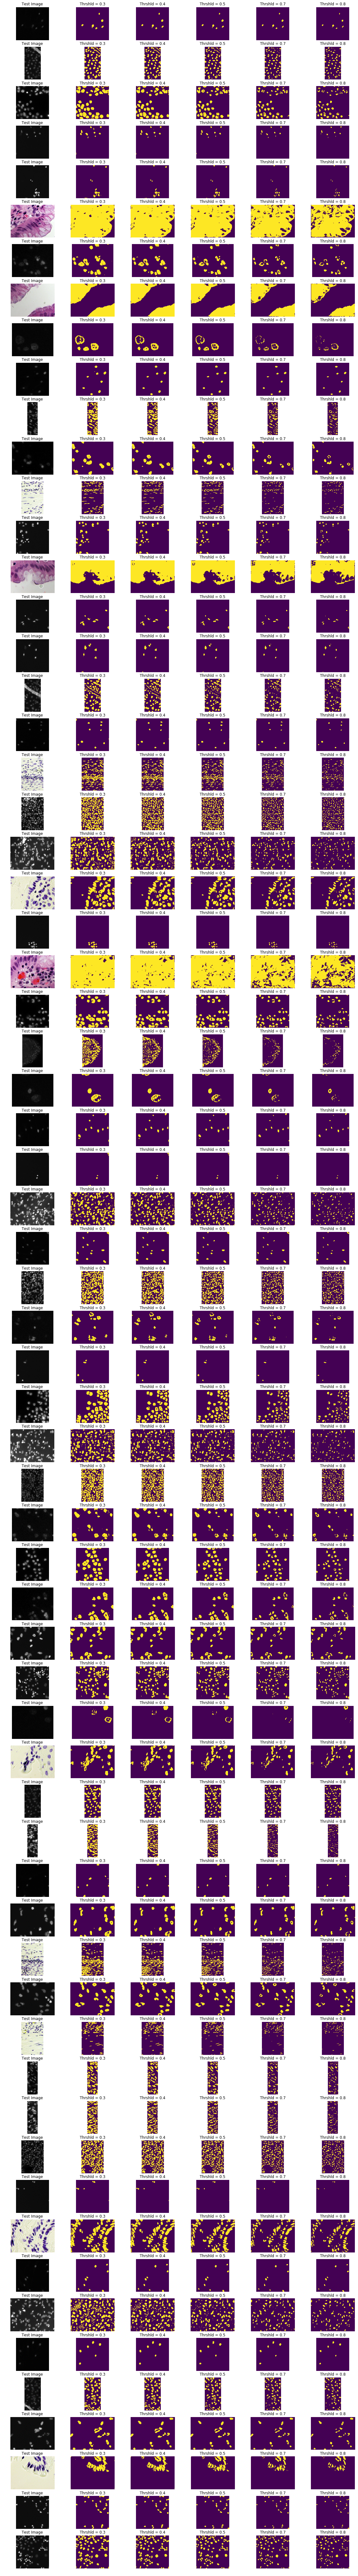

In [95]:
f, ax = plt.subplots(Test_Images.shape[0], 6, figsize=(20,150))
i = 0
for image, mask in zip(Test_Images_Orig, Pred_Masks_upsampled):
    ax[i,0].imshow(image[:,:,:3])
    ax[i,0].axis('Off')
    m = np.where(mask>0.3, 1, 0)
    ax2 = ax[i,1].imshow(m)
    ax[i,1].axis('Off')
    m = np.where(mask>0.4, 1, 0)
    ax2 = ax[i,2].imshow(m)
    ax[i,2].axis('Off')
    m = np.where(mask>0.5, 1, 0)
    ax2 = ax[i,3].imshow(m)
    ax[i,3].axis('Off')
    m = np.where(mask>0.7, 1, 0)
    ax2 = ax[i,4].imshow(m)
    ax[i,4].axis('Off')
    m = np.where(mask>0.8, 1, 0)
    ax2 = ax[i,5].imshow(m)
    ax[i,5].axis('Off')
    
    ax[i,0].set_title('Test Image')
    ax[i,1].set_title('Thrshld = 0.3')
    ax[i,2].set_title('Thrshld = 0.4')
    ax[i,3].set_title('Thrshld = 0.5')
    ax[i,4].set_title('Thrshld = 0.7')
    ax[i,5].set_title('Thrshld = 0.8')

    i = i+1
plt.show()

# Generating Submittion File

In [96]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [97]:
new_test_ids = []
rles = []
for n, id_ in enumerate(Test_Id):
    rle = list(prob_to_rles(Pred_Masks_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [41]:
submission_df = pd.DataFrame()
submission_df['ImageId'] = new_test_ids
submission_df['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
submission_df.to_csv('FCN_Submission.csv', index=False)